

```
Write a report (in LATEX)
• Name it « Report.3.cuda.tex »
• Explain how you implement the labwork
• Try experimenting with different block size values
• Plot a graph of block size vs time
• Discuss the graph
• Push the report and your code to your forked repository
```



In [1]:
!wget https://64.media.tumblr.com/5e0c6acb25df56613907574c0cd244e4/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg

--2024-10-13 09:01:08--  https://64.media.tumblr.com/5e0c6acb25df56613907574c0cd244e4/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg
Resolving 64.media.tumblr.com (64.media.tumblr.com)... 192.0.77.3
Connecting to 64.media.tumblr.com (64.media.tumblr.com)|192.0.77.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443180 (433K) [image/jpeg]
Saving to: ‘tumblr_mhwsoaQpXT1rttifoo1_1280.jpg’

tumblr_mhwsoaQpXT1r 100%[===================>] 432.79K  --.-KB/s    in 0.06s   

2024-10-13 09:01:08 (6.75 MB/s) - ‘tumblr_mhwsoaQpXT1rttifoo1_1280.jpg’ saved [443180/443180]



# convert grayscale sequentially

## version1

Time taken: 3.7691874504089355 seconds


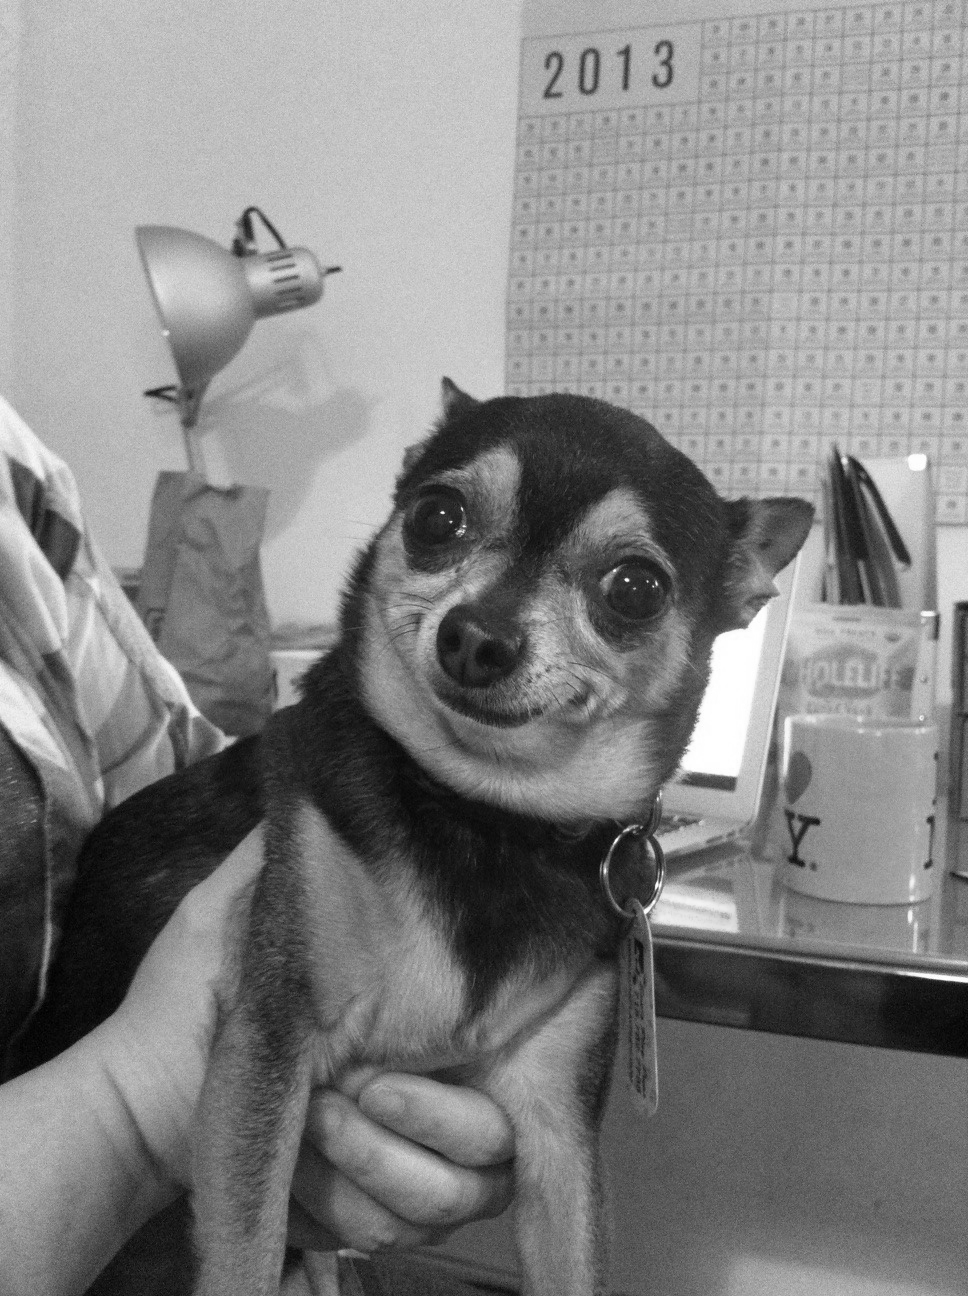

In [4]:
from PIL import Image
import time
from IPython.display import display

# Start the timer
start_time = time.time()

# Load the image
img = Image.open('/content/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg')

# Convert the image to grayscale manually using average formula
gray_img = img.convert("RGB")
width, height = gray_img.size

for x in range(width):
    for y in range(height):
        r, g, b = gray_img.getpixel((x, y))
        # Calculate grayscale value by averaging R, G, B
        gray = int((r + g + b) / 3)
        # Set pixel to the new grayscale value
        gray_img.putpixel((x, y), (gray, gray, gray))

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Display the grayscale image using IPython
display(gray_img)


## version2

Time taken: 2.02103328704834 seconds


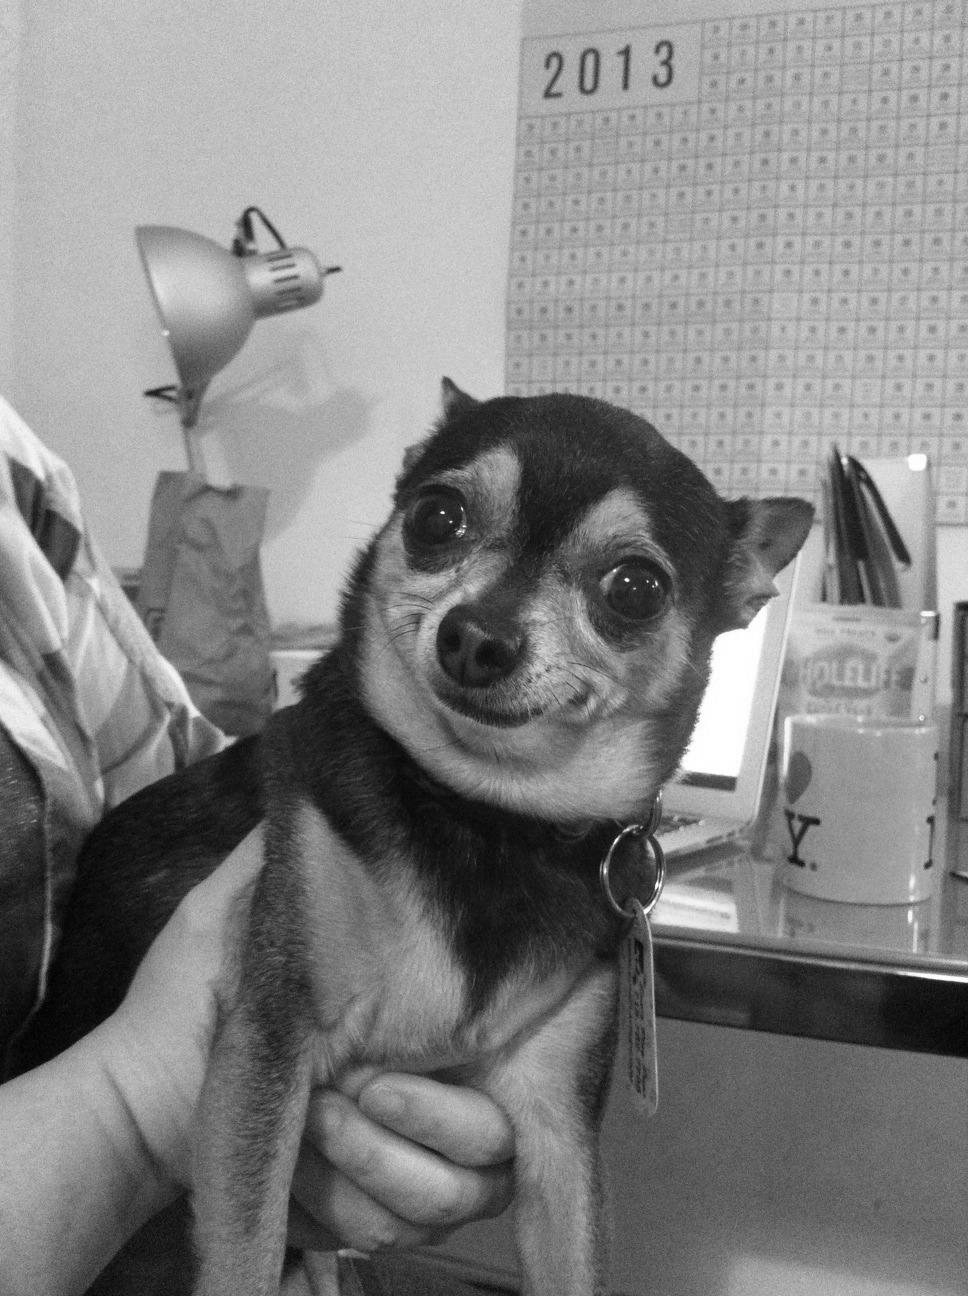

In [10]:
from PIL import Image
import time
from IPython.display import display

# Start the timer
start_time = time.time()

# Load the image
img = Image.open('/content/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg')

rgb_array = np.array(img)
# Create an empty array for the grayscale image
gray_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

# # Convert the image to grayscale manually using average formula
width, height = gray_array.shape[0], gray_array.shape[1]

for x in range(width):
    for y in range(height):
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        gray_array[x, y] = int((float(r) + float(g) + float(b)) / 3)


# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Display the grayscale image using IPython
display(gray_img)

# GPU version

## thread per block 16x16

Time taken: 0.15901541709899902 seconds


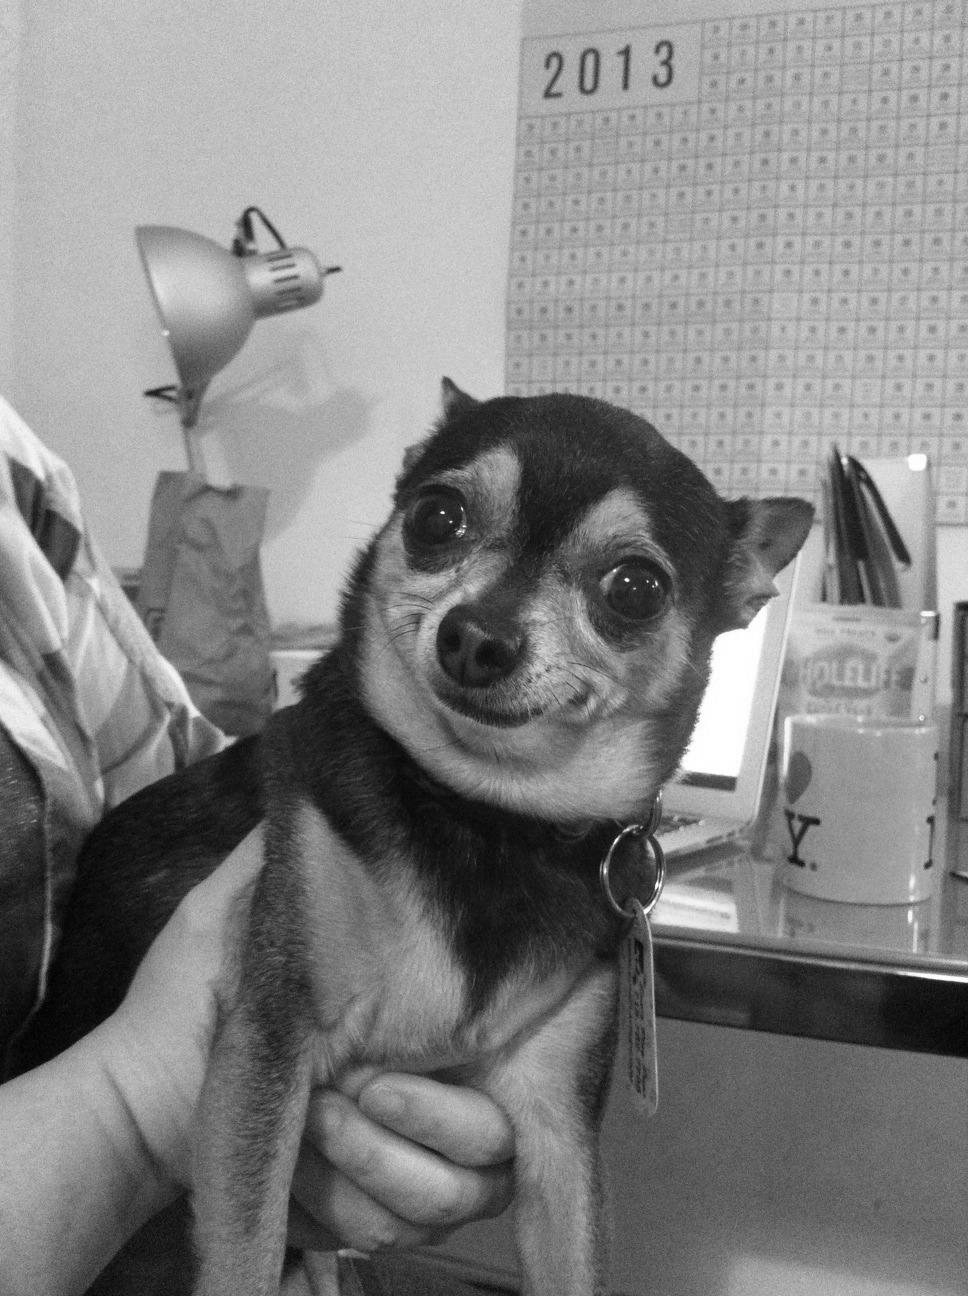

In [20]:
from PIL import Image
import time
from IPython.display import display
from numba import cuda
import numpy as np

# Function to convert the image to grayscale on the GPU
'''
3. Device processes data in parallel (Parallel Execution)
'''
@cuda.jit
def rgb_to_gray_gpu(rgb_array, gray_array):
    x, y = cuda.grid(2)
    if x < rgb_array.shape[0] and y < rgb_array.shape[1]:
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        # Average formula for grayscale
        gray_value = (r + g + b) // 3
        gray_array[x, y] = gray_value

# Start the timer
start_time = time.time()

# Load the image and convert to NumPy array
img = Image.open('/content/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg')
rgb_array = np.array(img)

# Create an empty array for the grayscale image
gray_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

# Define the block and grid size for GPU execution
threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(rgb_array.shape[0] / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(rgb_array.shape[1] / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

'''
1. Host feeds device with data (Data Transfer from Host to Device)
'''
# Copy data to the GPU
rgb_array_device = cuda.to_device(rgb_array)
gray_array_device = cuda.to_device(gray_array)

# Run the kernel on the GPU
'''
2. Host asks device to process data (Kernel Launch)
'''
rgb_to_gray_gpu[blocks_per_grid, threads_per_block](rgb_array_device, gray_array_device)

'''
4. Device returns result (Data Transfer from Device to Host)
'''
# Copy the result back to the host
gray_array_device.copy_to_host(gray_array)

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Convert the grayscale array back to an image
gray_img = Image.fromarray(gray_array)

# Display the grayscale image using IPython
display(gray_img)


## threads_per_block in [(4,4),(8,8),(16, 16), (24, 24), (32, 32),(40, 40),(48, 48),(56, 56),(64,64),(72,72)]

In [23]:
from PIL import Image
import time
from IPython.display import display
from numba import cuda
import numpy as np

# Function to convert the image to grayscale on the GPU
'''
3. Device processes data in parallel (Parallel Execution)
'''
@cuda.jit
def rgb_to_gray_gpu(rgb_array, gray_array):
    x, y = cuda.grid(2)
    if x < rgb_array.shape[0] and y < rgb_array.shape[1]:
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        # Average formula for grayscale
        gray_value = (r + g + b) // 3
        gray_array[x, y] = gray_value

for i in [(1,1),(2,2),(4,4),(6,6),(8,8),(10,10),(16, 16), (24, 24), (32, 32)]:
  # Start the timer
  start_time = time.time()

  # Load the image and convert to NumPy array
  img = Image.open('/content/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg')
  rgb_array = np.array(img)

  # Create an empty array for the grayscale image
  gray_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

  # Define the block and grid size for GPU execution
  threads_per_block = i
  blocks_per_grid_x = int(np.ceil(rgb_array.shape[0] / threads_per_block[0]))
  blocks_per_grid_y = int(np.ceil(rgb_array.shape[1] / threads_per_block[1]))
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  '''
  1. Host feeds device with data (Data Transfer from Host to Device)
  '''
  # Copy data to the GPU
  rgb_array_device = cuda.to_device(rgb_array)
  gray_array_device = cuda.to_device(gray_array)

  # Run the kernel on the GPU
  '''
  2. Host asks device to process data (Kernel Launch)
  '''
  rgb_to_gray_gpu[blocks_per_grid, threads_per_block](rgb_array_device, gray_array_device)

  '''
  4. Device returns result (Data Transfer from Device to Host)
  '''
  # Copy the result back to the host
  gray_array_device.copy_to_host(gray_array)

  # End the timer
  end_time = time.time()
  print(f"Time taken for {threads_per_block} thread per block: {end_time - start_time} seconds")



Time taken for (1, 1) thread per block: 0.16016292572021484 seconds
Time taken for (2, 2) thread per block: 0.027263641357421875 seconds
Time taken for (4, 4) thread per block: 0.027539730072021484 seconds
Time taken for (6, 6) thread per block: 0.02643442153930664 seconds
Time taken for (8, 8) thread per block: 0.02390313148498535 seconds
Time taken for (10, 10) thread per block: 0.02353048324584961 seconds
Time taken for (16, 16) thread per block: 0.024882078170776367 seconds
Time taken for (24, 24) thread per block: 0.027444124221801758 seconds
Time taken for (32, 32) thread per block: 0.026804208755493164 seconds


In [16]:
from numba import cuda

print("Max threads per block:", cuda.get_current_device().MAX_THREADS_PER_BLOCK)
print("Max grid size:", cuda.get_current_device().MAX_GRID_DIM_X, cuda.get_current_device().MAX_GRID_DIM_Y, cuda.get_current_device().MAX_GRID_DIM_Z)


Max threads per block: 1024
Max grid size: 2147483647 65535 65535


# Plot the effect of threads per block

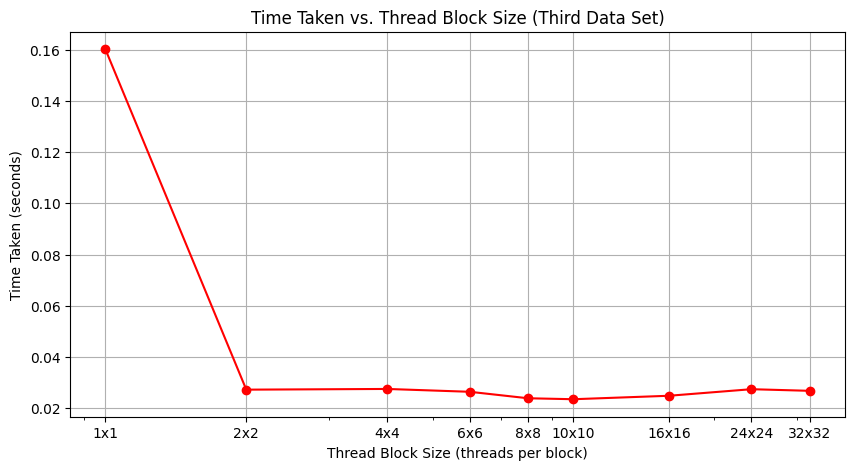

In [24]:
# New data for the third plot
third_thread_block_sizes = [(1, 1), (2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (16, 16), (24, 24), (32, 32)]
third_time_taken = [
    0.16016292572021484,
    0.027263641357421875,
    0.027539730072021484,
    0.02643442153930664,
    0.02390313148498535,
    0.02353048324584961,
    0.024882078170776367,
    0.027444124221801758,
    0.026804208755493164,
]

# Extract thread sizes for the x-axis
third_sizes = [size[0] for size in third_thread_block_sizes]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(third_sizes, third_time_taken, marker='o', linestyle='-', color='r')
plt.xscale('log')  # Use logarithmic scale for better visibility
plt.xticks(third_sizes, labels=[f"{size[0]}x{size[1]}" for size in third_thread_block_sizes])
plt.xlabel('Thread Block Size (threads per block)')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs. Thread Block Size (Third Data Set)')
plt.grid(True)
plt.show()
